## setup env 

In [1]:
import os
import cv2
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
!pip install git+https://github.com/miykael/gif_your_nifti 
import gif_your_nifti.core as gif2nif
# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical   
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard



np.set_printoptions(precision=3, suppress=True)

  Cloning https://github.com/miykael/gif_your_nifti to c:\users\bisha\appdata\local\temp\pip-req-build-cq7dbgv7
  Resolved https://github.com/miykael/gif_your_nifti to commit bcf9c0a2f4a755792548085b2f766ad415f91385
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/miykael/gif_your_nifti 'C:\Users\bisha\AppData\Local\Temp\pip-req-build-cq7dbgv7'


## Define Constants

In [2]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# days start interval
SURVIVAL_CATEGORIES= {
    'SHORT' : 0 , # 0-300
    'MEDIUM' : 300,  # 300-450
    'LONG' : 450, # 450 and more
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128
TRAIN_DATASET_PATH='C:/Users/bisha/Desktop/archive (2)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

## Split Dataset into train/test/validation

In [3]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]
# file BraTS20_Training_355 has ill formatted name for for seg.nii file
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

## Check if the background of images contains only zero values

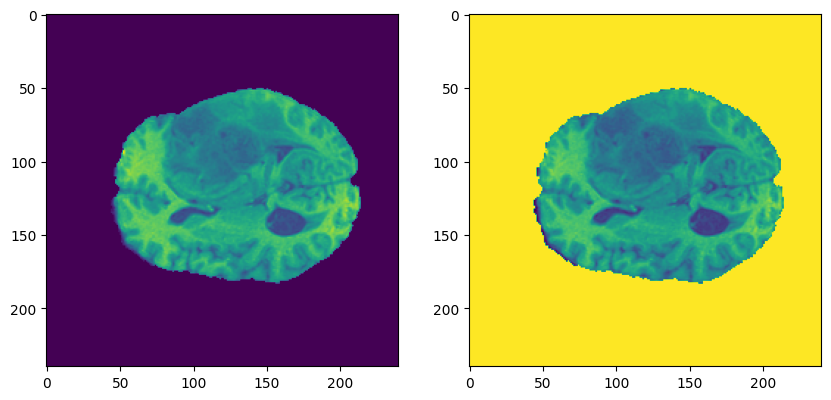

In [4]:
my_loc_slice=73
image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
my_img=image_volume[:,:,my_loc_slice]
my_converted_img = my_img.copy()
my_converted_img[my_converted_img == 0] = 666


f, axarr = plt.subplots(1,2, figsize = (10, 5))
axarr[0].imshow(my_img)
axarr[1].imshow(my_converted_img)

##### Count number of pixels for each segment for each slice in volume 

In [5]:
def maskSizeForSlice(path,i_slice):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    image_volume=nib.load(path).get_fdata()
    # flatten 3D image into 1D array and convert mask 4 to 2
    arr=image_volume[:,:,i_slice].flatten()
    arr[arr == 4] = 3

    unique, counts = np.unique(arr, return_counts=True)
    unique = unique.astype(int)
    values_dict=dict(zip(unique, counts))
    for k in range(1,4):
        totals[k] += values_dict.get(k,0)
    return totals

count class 1: 287
{1: 287, 2: 3843, 3: 631}


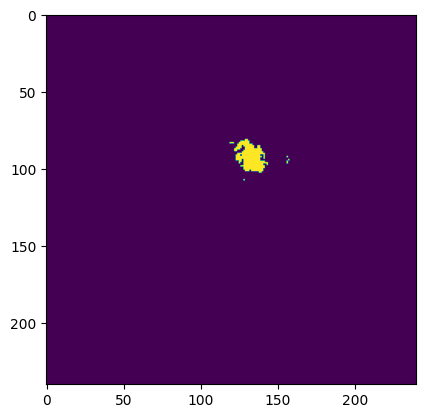

In [6]:
my_loc_slice=73
my_loc_class=1
seg_sum=maskSizeForSlice(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii',my_loc_slice)


image_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()
image_loc=image_volume[:,:,my_loc_slice]
image_loc[image_loc != my_loc_class] = 0

# plot segment only for class 'my_loc_class'
plt.imshow(image_loc)

image_loc=image_loc.flatten()
count = np.count_nonzero(image_loc == my_loc_class)
print(f'count class {my_loc_class}: {count}')
print(seg_sum)

# Survival prediction

##### Lets see what is the age distrubution in our dataset and their survival days

In [7]:
import csv

csv_path = "C:/Users/bisha/Desktop/archive (2)/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/survival_info.csv"
age_dict = {}
days_dict = {}


with open(csv_path, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
  #  row_count = sum(1 for row in csv_reader)
 #   print(f'total rows: {row_count} .')
    at_line = 0
    category_short = 0
    category_medium = 0
    category_long = 0
    max_days = 0
    for row in csv_reader:
        if at_line == 0:
            print(f'Column names are {", ".join(row)}')
            at_line += 1
        else:
            if (row[3] != "GTR"):
                continue
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            if (not days.isnumeric()):
                continue
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            max_days = max(max_days,int(days))
            if int(days) < 250:
                category_short += 1
            elif (int(days) >= 250 and int(days) <= 450):
                category_medium += 1
            else:
                category_long += 1
            at_line+=1

    print(f'Processed {at_line} lines.')
    print(category_short,category_medium,category_long)
    print(max_days)

Column names are Brats20ID, Age, Survival_days, Extent_of_Resection
['BraTS20_Training_001', '60.463', '289', 'GTR']
['BraTS20_Training_002', '52.263', '616', 'GTR']
['BraTS20_Training_003', '54.301', '464', 'GTR']
['BraTS20_Training_004', '39.068', '788', 'GTR']
['BraTS20_Training_005', '68.493', '465', 'GTR']
['BraTS20_Training_006', '67.126', '269', 'GTR']
['BraTS20_Training_007', '69.912', '503', 'GTR']
['BraTS20_Training_009', '56.419', '1155', 'GTR']
['BraTS20_Training_010', '48.367', '515', 'GTR']
['BraTS20_Training_012', '65.899', '495', 'GTR']
['BraTS20_Training_013', '59.693', '698', 'GTR']
['BraTS20_Training_014', '51.734', '359', 'GTR']
['BraTS20_Training_015', '62.614', '169', 'GTR']
['BraTS20_Training_016', '55.759', '368', 'GTR']
['BraTS20_Training_017', '58.258', '439', 'GTR']
['BraTS20_Training_018', '61.605', '486', 'GTR']
['BraTS20_Training_019', '68.049', '287', 'GTR']
['BraTS20_Training_021', '56.921', '576', 'GTR']
['BraTS20_Training_022', '44.162', '350', 'GTR']


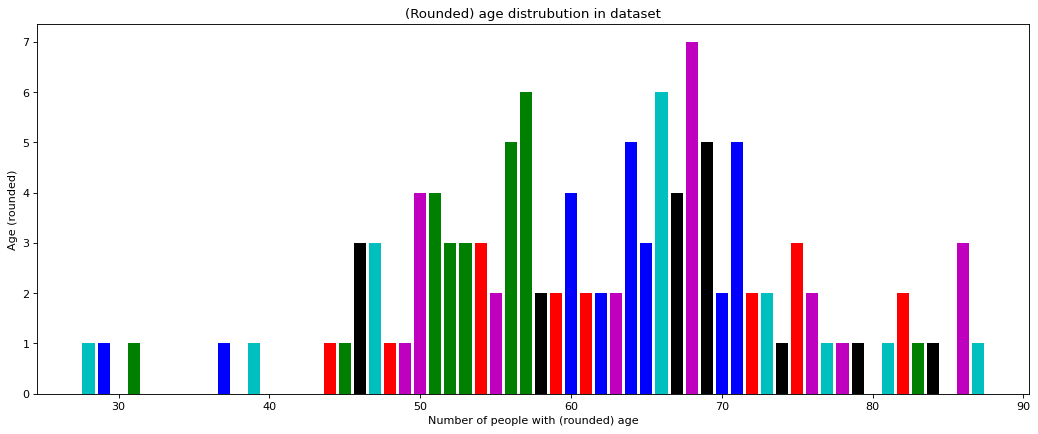

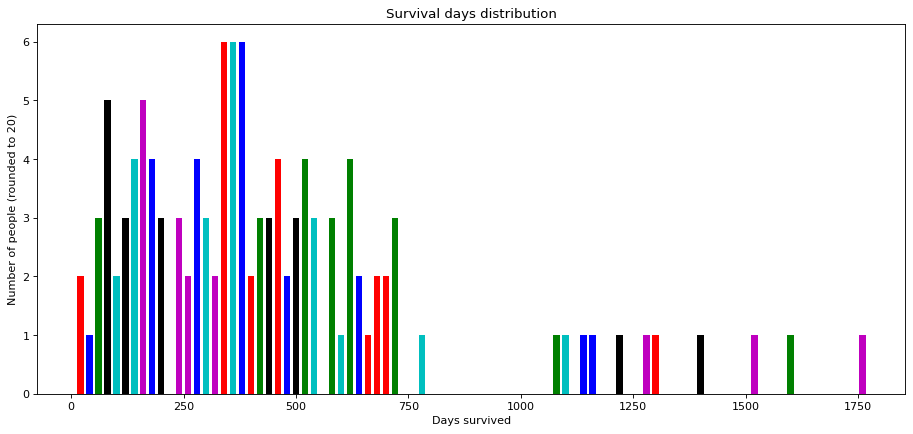

In [8]:
from collections import Counter
from itertools import cycle
#age_dict, days_dict 

# round values in dictionary
age_dict_rounded = {key : round(age_dict[key], 0) for key in age_dict}
# survival days are very distinct values => move the values in ranges per 20
days_dict_rounded = {key : round(days_dict[key]/20)*20 for key in days_dict}

# count same numbers => create statistics how many times is there person with same age
age_dict_rounded_counted = Counter(age_dict_rounded.values())
days_dict_rounded_counted = Counter(days_dict_rounded.values())

cycol = cycle('bgrcmk')
colors = list()
for i in range(len(age_dict_rounded_counted)):
    colors.append(next(cycol))
    
cycol = cycle('bgrcmk')    
colorsDays = list()
for i in range(len(days_dict_rounded_counted)):
    colorsDays.append(next(cycol))

plt.figure(figsize=(16, 6), dpi=80)
plt.xlabel('Number of people with (rounded) age')
plt.ylabel('Age (rounded)')
plt.title("(Rounded) age distrubution in dataset")
plt.bar(list(age_dict_rounded_counted.keys()), age_dict_rounded_counted.values(), color=colors)
plt.show()

plt.figure(figsize=(14, 6), dpi=80)
plt.xlabel('Days survived')
plt.ylabel('Number of people (rounded to 20)')
plt.title("Survival days distribution")
plt.bar(list(days_dict_rounded_counted.keys()), days_dict_rounded_counted.values(),width=15, color=colorsDays)
plt.show()

### Computing segment sizes


In [9]:
# get number of pixels for each segment as dictionary
# original images contain segment values (0,1,2,4) => 4 is our 3 ... :)
def getMaskSizesForVolume(image_volume):
    totals = dict([(1, 0), (2, 0), (3, 0)])
    for i in range(VOLUME_SLICES):
        # flatten 2D image into 1D array and convert mask 4 to 2
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        arr[arr == 4] = 3
        
        unique, counts = np.unique(arr, return_counts=True)
        unique = unique.astype(int)
        values_dict=dict(zip(unique, counts))
        for k in range(1,4):
            totals[k] += values_dict.get(k,0)
    return totals

##### Compute brain volume size

total count: 1264556


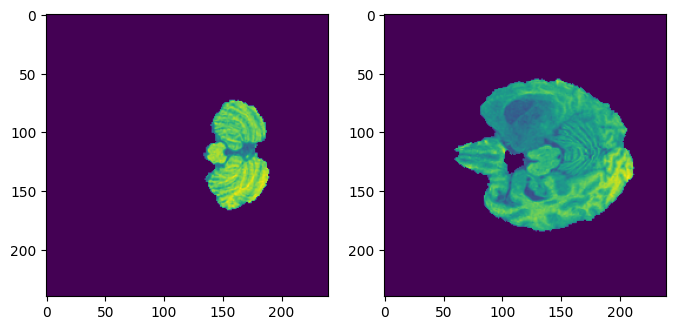

In [10]:
# returns count of non zero elements in whole 3D volume
def getBrainSizeForVolume(image_volume):
    total = 0
    for i in range(VOLUME_SLICES):
        arr=image_volume[:,:,i+VOLUME_START_AT].flatten()
        image_count=np.count_nonzero(arr)
        total=total+image_count
    return total

example_volume=nib.load(TRAIN_DATASET_PATH+'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()

f, axarr = plt.subplots(1,2, figsize = (8, 4))
axarr[0].imshow(example_volume[:,:,VOLUME_START_AT])
axarr[1].imshow(example_volume[:,:,VOLUME_START_AT+30])

print(f'total count: {getBrainSizeForVolume(example_volume)}')

In [ ]:
# create only age: category data

# id: age, categories
def getListAgeDays(id_list):
    x_val = []
    y_val = []
    for i in id_list:
        if (i not in age_dict):
            continue
        masks = getMaskSizesForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_seg.nii').get_fdata())
        brain_vol = getBrainSizeForVolume(nib.load(TRAIN_DATASET_PATH + f'BraTS20_Training_{i[-3:]}/BraTS20_Training_{i[-3:]}_t1.nii').get_fdata())
        masks[1] = masks[1]/brain_vol
        masks[2] = masks[2]/brain_vol
        masks[3] = masks[3]/brain_vol
        merged=[age_dict[i],masks[1],masks[2],masks[3]] ## add segments
        x_val.append(merged) 
        if (days_dict[i] < 250):
            y_val.append([1,0,0])
        elif (days_dict[i] >= 250 and days_dict[i] < 450):
            y_val.append([0,1,0])
        else:
            y_val.append([0,0,1])
            
    return np.array(x_val), np.array(y_val)

X_all, y_all = getListAgeDays(train_and_test_ids)

print(f'X_test: {X_all.shape}')
df = pd.DataFrame(np.concatenate((X_all, y_all), axis=1) , columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}","short","medium","long"])
df.head()

## Normalize the data

In [12]:
scaler = MinMaxScaler()
v = X_all
v_scaled = scaler.fit_transform(v)
X_all = v_scaled

df = pd.DataFrame(X_all, columns = ["age normalised",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])
display(df)

,age normalised,NECROTIC/CORE,EDEMA,ENHANCING
0,0.554919,0.300803,1.000000,0.454172
1,0.415561,0.156439,0.256189,0.092798
2,0.450196,0.015714,0.158396,0.052678
3,0.191312,0.190553,0.401585,0.226916
4,0.691389,0.066131,0.025554,0.164851
...,...,...,...,...
113,0.377101,0.361332,0.295488,1.000000
114,0.496066,0.462719,0.284498,0.758763
115,0.750990,0.097765,0.159742,0.414221
116,0.360106,0.026015,0.380664,0.273045


##### Train test split

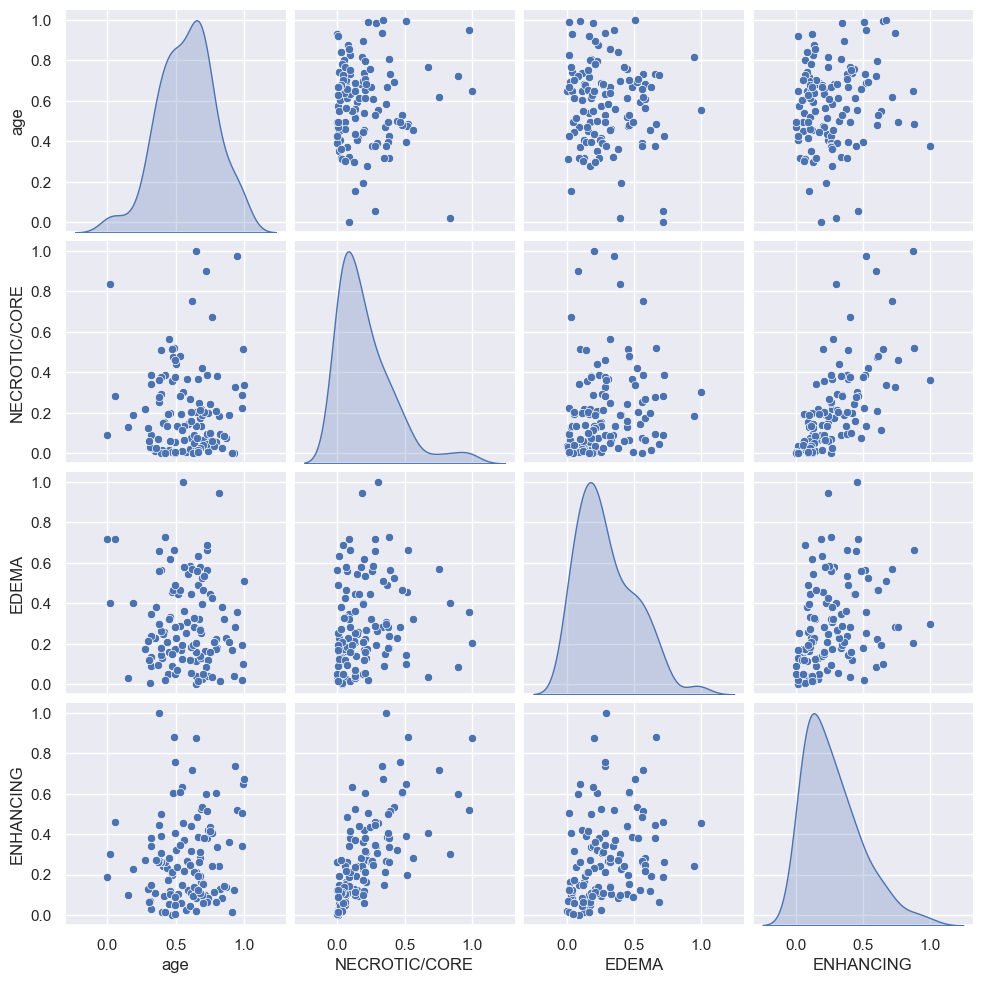

In [13]:
sns.set()

df = pd.DataFrame(X_all, columns = ["age", SEGMENT_CLASSES[1],SEGMENT_CLASSES[2],SEGMENT_CLASSES[3]])
sns.pairplot(df, diag_kind='kde')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_all,y_all,test_size = 0.2, random_state = 42, shuffle = True)


print("x_train shape:",X_train.shape)
print("x_test shape:", X_train.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (94, 4)
x_test shape: (94, 4)
y_train shape: (94, 3)
y_test shape: (24, 3)


## Random forest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier(n_estimators=3, random_state=0)

# fit the model to the training set
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Model accuracy score with 3 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))



accuracies = cross_val_score(rfc, X_train, y_train, cv=3)
# rfc.fit(X_train,y_train)

print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",rfc.score(X_test,y_test))

Model accuracy score with 3 decision-trees : 0.5000
Cross validation: Train Score: 0.3951612903225807
Cross validation: Test Score: 0.5


###### Visualize the most important features 

In [16]:
df = pd.DataFrame(X_train, columns = ["age",f"{SEGMENT_CLASSES[1]}",f"{SEGMENT_CLASSES[2]}",f"{SEGMENT_CLASSES[3]}"])

feature_scores = pd.Series(rfc.feature_importances_, index=df.columns).sort_values(ascending=False)
feature_scores

age              0.346818
EDEMA            0.233833
NECROTIC/CORE    0.213103
ENHANCING        0.206246
dtype: float64

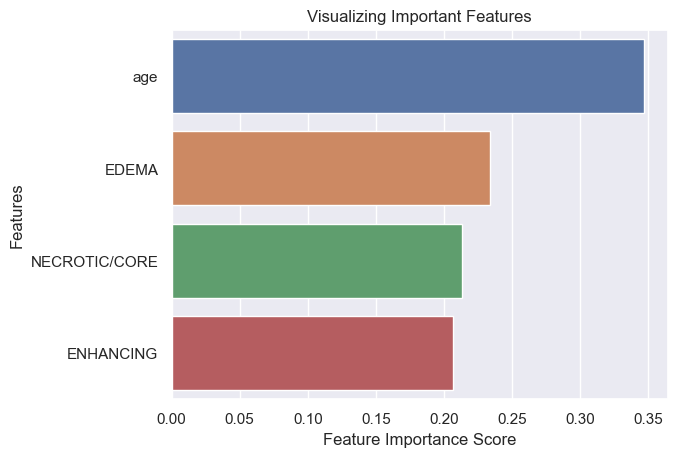

In [17]:
sns.barplot(x=feature_scores, y=feature_scores.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Confusion matrix

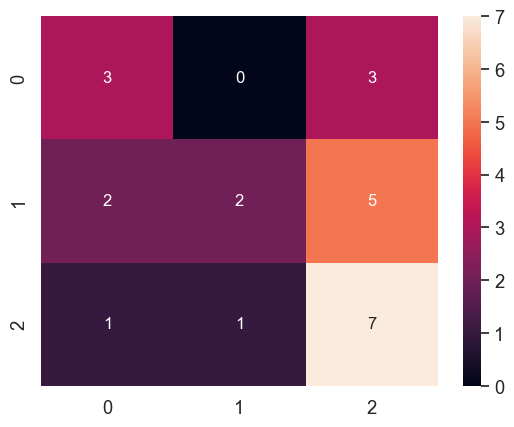

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

### Gridsearch

In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.67      0.22      0.33         9
           2       0.47      0.78      0.58         9

   micro avg       0.52      0.50      0.51        24
   macro avg       0.58      0.50      0.49        24
weighted avg       0.58      0.50      0.48        24
 samples avg       0.50      0.50      0.50        24



C:\Users\bisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
grid = {
    'n_estimators':np.arange(1,100,1),
    'criterion':['gini','entropy']
    }

rfc_ = RandomForestClassifier(random_state = 42)
rf_grid = GridSearchCV(rfc_, grid, cv=5)
rf_grid.fit(X_train,y_train)

print("Hyperparameters:",rf_grid.best_params_)
print("Train Score:", rf_grid.best_score_)
print("Test Score:",rf_grid.score(X_test,y_test))

Hyperparameters: {'criterion': 'gini', 'n_estimators': 11}
Train Score: 0.38304093567251457
Test Score: 0.2916666666666667


## SVM classifier

In [21]:
from sklearn.svm import SVC

#convert one hot into multilabel
y_train_multi=np.argmax(y_train, axis=1)
y_test_multi =np.argmax(y_test, axis=1)

svc = SVC(random_state = 42, C=10, degree=3, gamma=1, kernel='poly')
svc.fit(X_train,y_train_multi)
accuracies = cross_val_score(svc, X_train, y_train_multi)


y_pred = svc.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",svc.score(X_test,y_test_multi))

Model accuracy score : 0.4167
Cross validation: Train Score: 0.43801169590643274
Cross validation: Test Score: 0.4166666666666667


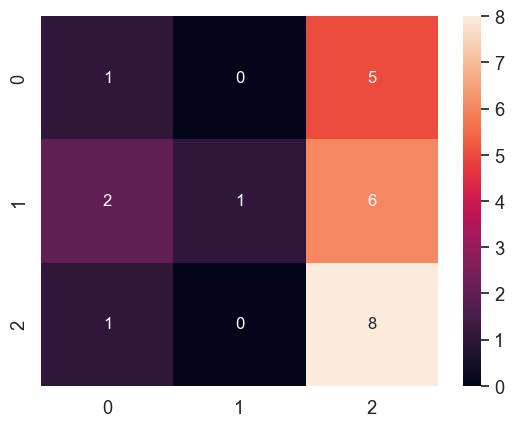

In [22]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [23]:
print(classification_report(y_test_multi, y_pred))


              precision    recall  f1-score   support

           0       0.25      0.17      0.20         6
           1       1.00      0.11      0.20         9
           2       0.42      0.89      0.57         9

    accuracy                           0.42        24
   macro avg       0.56      0.39      0.32        24
weighted avg       0.60      0.42      0.34        24



In [24]:
grid = {
    'C':[0.01,0.1,1,10,15,20],
    'kernel' : ["linear","poly","rbf","sigmoid"],
    'degree' : [1,3,5,7],
    'gamma' : [0.01,1]
}

svm  = SVC();
svm_grid = GridSearchCV(svm, grid, cv = 5)
svm_grid.fit(X_train,y_train_multi)
print("Best Parameters:",svm_grid.best_params_)
print("Train Score:",svm_grid.best_score_)
print("Test Score:",svm_grid.score(X_test,y_test_multi))

Best Parameters: {'C': 20, 'degree': 5, 'gamma': 1, 'kernel': 'poly'}
Train Score: 0.46900584795321637
Test Score: 0.4166666666666667


## KNN Classifier 

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn  = KNeighborsClassifier(n_neighbors=38, p=2, weights='distance')
knn.fit(X_train,y_train_multi)
accuracies = cross_val_score(knn, X_train, y_train_multi)

y_pred = knn.predict(X_test)

print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test_multi, y_pred)))


print("Cross validation: Train Score:",np.mean(accuracies))
print("Cross validation: Test Score:",knn.score(X_test,y_test_multi))

Model accuracy score : 0.3750
Cross validation: Train Score: 0.415204678362573
Cross validation: Test Score: 0.375


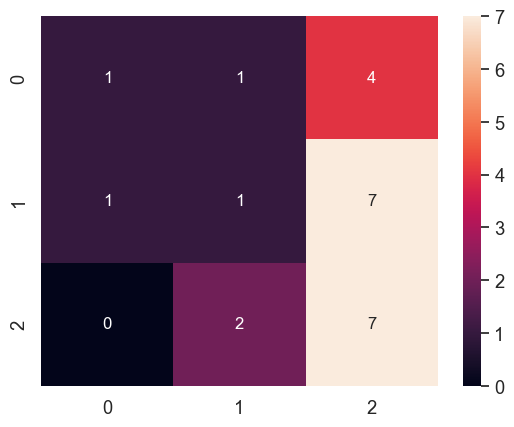

In [26]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [27]:
print(classification_report(y_test_multi, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.25      0.11      0.15         9
           2       0.39      0.78      0.52         9

    accuracy                           0.38        24
   macro avg       0.38      0.35      0.31        24
weighted avg       0.36      0.38      0.31        24



In [28]:
grid = {
    'n_neighbors':np.arange(1,75),
    'p':np.arange(1,5),
    'weights':['uniform','distance']
    }

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn,grid,cv=5)
knn_grid.fit(X_train,y_train_multi)

print("Hyperparameters:",knn_grid.best_params_)
print("Train Score:",knn_grid.best_score_)
print("Test Score:",knn_grid.score(X_test,y_test_multi))

Hyperparameters: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Train Score: 0.5005847953216375
Test Score: 0.4166666666666667


## MLP Classifier

Iteration 1, loss = 1.23779905
Iteration 2, loss = 1.23220432
Iteration 3, loss = 1.22666243
Iteration 4, loss = 1.22119872
Iteration 5, loss = 1.21581646
Iteration 6, loss = 1.21051677
Iteration 7, loss = 1.20532111
Iteration 8, loss = 1.20020651
Iteration 9, loss = 1.19517990
Iteration 10, loss = 1.19025111
Iteration 11, loss = 1.18542411
Iteration 12, loss = 1.18067306
Iteration 13, loss = 1.17599487
Iteration 14, loss = 1.17139730
Iteration 15, loss = 1.16688629
Iteration 16, loss = 1.16245214
Iteration 17, loss = 1.15810694
Iteration 18, loss = 1.15388003
Iteration 19, loss = 1.14976887
Iteration 20, loss = 1.14576191
Iteration 21, loss = 1.14183340
Iteration 22, loss = 1.13797848
Iteration 23, loss = 1.13419560
Iteration 24, loss = 1.13047258
Iteration 25, loss = 1.12680850
Iteration 26, loss = 1.12322025
Iteration 27, loss = 1.11970458
Iteration 28, loss = 1.11622823
Iteration 29, loss = 1.11282771
Iteration 30, loss = 1.10949336
Iteration 31, loss = 1.10621928
Iteration 32, los

C:\Users\ripun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ripun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ripun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 151, loss = 0.91747498
Iteration 152, loss = 0.91633270
Iteration 153, loss = 0.91519650
Iteration 154, loss = 0.91408452
Iteration 155, loss = 0.91298267
Iteration 156, loss = 0.91191631
Iteration 157, loss = 0.91084562
Iteration 158, loss = 0.90977821
Iteration 159, loss = 0.90871347
Iteration 160, loss = 0.90766233
Iteration 161, loss = 0.90661810
Iteration 162, loss = 0.90558012
Iteration 163, loss = 0.90454624
Iteration 164, loss = 0.90351186
Iteration 165, loss = 0.90247953
Iteration 166, loss = 0.90145441
Iteration 167, loss = 0.90042940
Iteration 168, loss = 0.89940966
Iteration 169, loss = 0.89840184
Iteration 170, loss = 0.89739237
Iteration 171, loss = 0.89638985
Iteration 172, loss = 0.89539385
Iteration 173, loss = 0.89440729
Iteration 174, loss = 0.89342532
Iteration 175, loss = 0.89243955
Iteration 176, loss = 0.89145492
Iteration 177, loss = 0.89047337
Iteration 178, loss = 0.88949685
Iteration 179, loss = 0.88852364
Iteration 180, loss = 0.88754933
Iteration 

C:\Users\ripun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ripun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ripun\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 300, loss = 0.70682718
Iteration 1, loss = 1.22582683
Iteration 2, loss = 1.22002275
Iteration 3, loss = 1.21427829
Iteration 4, loss = 1.20859023
Iteration 5, loss = 1.20297915
Iteration 6, loss = 1.19744644
Iteration 7, loss = 1.19199104
Iteration 8, loss = 1.18657946
Iteration 9, loss = 1.18124056
Iteration 10, loss = 1.17597870
Iteration 11, loss = 1.17080094
Iteration 12, loss = 1.16571471
Iteration 13, loss = 1.16072943
Iteration 14, loss = 1.15582890
Iteration 15, loss = 1.15102797
Iteration 16, loss = 1.14631120
Iteration 17, loss = 1.14168751
Iteration 18, loss = 1.13717495
Iteration 19, loss = 1.13273355
Iteration 20, loss = 1.12836225
Iteration 21, loss = 1.12406266
Iteration 22, loss = 1.11983696
Iteration 23, loss = 1.11571555
Iteration 24, loss = 1.11166159
Iteration 25, loss = 1.10766708
Iteration 26, loss = 1.10372846
Iteration 27, loss = 1.09982887
Iteration 28, loss = 1.09598755
Iteration 29, loss = 1.09221523
Iteration 30, loss = 1.08852478
Iteration 31, lo

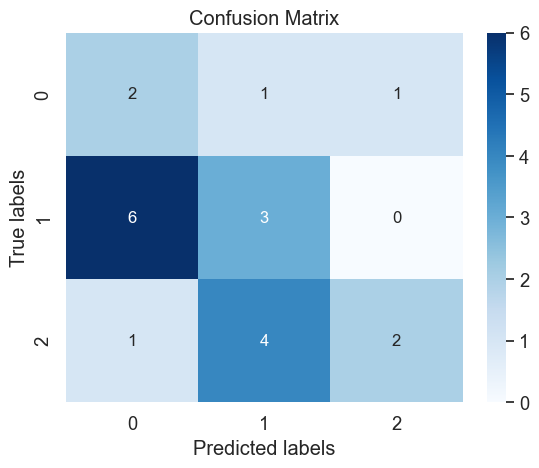

In [2]:
from sklearn.preprocessing import StandardScaler

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Updated MLPClassifier with 'adam' solver and increased max_iter
clf = MLPClassifier(
    hidden_layer_sizes=(11,),  # Ensure it's a tuple
    max_iter=300,  # Increased number of iterations
    alpha=1e-4,  # Adjusted regularization term
    solver='adam',  # Changed solver to 'adam'
    verbose=10,
    random_state=6,
    tol=1e-4  # Adjusted tolerance for stopping criteria
)

clf.fit(X_train_scaled, y_train_multi)  # Fit on scaled data
accuracies = cross_val_score(clf, X_train_scaled, y_train_multi, cv=5)  # Cross-validation on scaled data
y_pred = clf.predict(X_test_scaled)  # Predict on scaled test data

print('Model accuracy score : {0:0.4f}'.format(accuracy_score(y_test_multi, y_pred)))
print("Cross validation: Train Score:", np.mean(accuracies))

# Confusion Matrix calculation and visualization
cm = confusion_matrix(y_test_multi, y_pred)
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


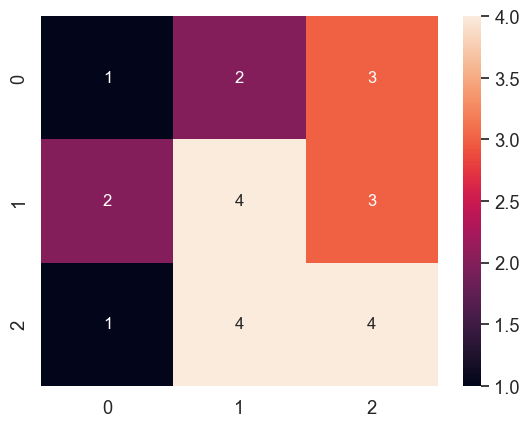

In [30]:
# convert to one hot
y_pred=y_pred.astype(int)
n_values = np.max(y_pred) + 1
y_pred_hot=np.eye(n_values)[y_pred]

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_hot.argmax(axis=1))

sns.set(font_scale=1.2) 
sns.heatmap(cm, annot=True, annot_kws={"size": 12}) 

plt.show()

In [32]:
grid = {
    'solver': ['lbfgs'],
    'max_iter': [25,50,100,150,200,300,500,1000 ],
    'alpha': 10.0 ** -np.arange(1, 10),
    'hidden_layer_sizes':np.arange(10, 15),
    'random_state':[0,1,2,3,4,5,6,7,8,9]
}
clf_grid = GridSearchCV(MLPClassifier(), grid, n_jobs=-1)

clf_grid.fit(X_train, y_train_multi)

print("Hyperparameters:",clf_grid.best_params_)
print("Train Score:",clf_grid.best_score_)
print("Test Score:",clf_grid.score(X_test, y_test_multi))

Hyperparameters: {'alpha': 1e-06, 'hidden_layer_sizes': 14, 'max_iter': 500, 'random_state': 5, 'solver': 'lbfgs'}
Train Score: 0.5637426900584795
Test Score: 0.4583333333333333


C:\Users\bisha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
